In [1]:
import json
import re
from haralyzer import HarParser
import pandas as pd
from datetime import datetime, timezone

# Load the HAR file
with open('Content_Creator_Tips_Archive [24-10-17 11-41-46].har', 'r', encoding='utf-8') as f:
    har_parser = HarParser(json.loads(f.read()))

#Check if it has data
data_from_har = har_parser.har_data
print(type(data_from_har))

# Regex patterns for matching variables
patterns = {
    'username': re.compile(r'"uniqueId"\s*:\s*"([^"]+)"'),
    'nickname': re.compile(r'"nickname"\s*:\s*"([^"]+)"'),
    'bio': re.compile(r'"signature"\s*:\s*"([^"]+)"'),
    'follower_count': re.compile(r'"followerCount"\s*:\s*(\d+)'),
    'video_description': re.compile(r'"desc"\s*:\s*"([^"]+)"'),
    'upload_time': re.compile(r'"createTime"\s*:\s*(\d+)'),
    'duration': re.compile(r'"duration"\s*:\s*(\d+)'),
    'sound': re.compile(r'"title"\s*:\s*"([^"]+)"'),
    'view_count': re.compile(r'"playCount"\s*:\s*(\d+)'),
    'comment_count': re.compile(r'"commentCount"\s*:\s*(\d+)'),
    'like_count': re.compile(r'"diggCount"\s*:\s*(\d+)'),
    'save_count': re.compile(r'"collectCount"\s*:\s*(\d+)'),
    'share_count': re.compile(r'"shareCount"\s*:\s*(\d+)')
}


<class 'dict'>


In [2]:
data = []

# Updated helper function to convert UNIX time to human-readable UTC format
def convert_unix_time(unix_time):
    return datetime.fromtimestamp(unix_time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')

# Iterate over pages and entries in the HAR file
for page in har_parser.pages:
    for entry in page.entries:
        # Ensure that the entry has a 'text' field in its response content
        response_text = entry['response']['content'].get('text', '')
        if response_text:
            # Try to load the text content as JSON
            try:
                response_data = json.loads(response_text)
                
                # Extract the list of videos (inside the "data" array)
                videos = response_data.get('data', [])  # 'data' contains the list of video objects
                
                # Iterate over each video in the "data" array
                for video in videos:
                    item = video.get('item', {})  # 'item' contains the details of each video
                    
                    # Extract the data for each video (item)
                    extracted_data = {}
                    for key, pattern in patterns.items():
                        match = pattern.search(json.dumps(item))  # Search inside each item object
                        extracted_data[key] = match.group(1) if match else None

                    # Convert UNIX time for upload_date if available
                    if extracted_data.get('upload_time'):
                        extracted_data['upload_time'] = convert_unix_time(int(extracted_data['upload_time']))

                    # Add the row to the dataset if relevant data was found
                    if any(extracted_data.values()):
                        data.append(extracted_data)

            except json.JSONDecodeError:
                print("Error decoding JSON response")
                continue

df = pd.DataFrame(data)

# Show the first few rows of the DataFrame to verify the extraction
print(len(df))
#print(df)


108


### Now, let's clean the data 

In [3]:
# Data from JSON file is imported as 'str' type. Convert to numeric.
# List of columns to convert to numeric
columns_to_convert = ['follower_count', 'view_count', 'comment_count', 'like_count', 'save_count', 'share_count']

# Convert all relevant columns to numeric in one step
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [4]:
# Hashtags are at the end of the video description. Let's put those in to a new column.
def extract_hashtags(description):
    hashtags = re.findall(r'#\w+', description)

    #Remove them from description to avoid repeating data
    clean_description = re.sub(r'#\w+', '', description).strip()
    return clean_description, hashtags  

df[['video_description', 'hashtags']] = df['video_description'].apply(
    lambda desc: pd.Series(extract_hashtags(desc) if pd.notnull(desc) else ('', []))
)

#print(df)

In [5]:
# Let's convert the emoji's for the humans in the audience.
import json
# Function to decode Unicode escape sequences safely
def decode_unicode(description):
    try:
        # Add quotes around the string so json.loads correctly decodes the escape sequences
        return json.loads(f'"{description}"')
    except json.JSONDecodeError:
        return description

# List of columns to apply the decoding function
columns_to_decode = ['video_description', 'nickname', 'bio']

# Apply the decoding function in place to all specified columns
df[columns_to_decode] = df[columns_to_decode].map(lambda desc: decode_unicode(desc) if pd.notnull(desc) else '')

# Show the resulting DataFrame with the decoded descriptions
#print(df[['video_description']])

# Save the cleaned data to a .csv for work elsewhere
df.to_csv('cleaned_tiktok_data.csv', index=False)


### Data Aggregation

In [6]:
#Calculate the rate of engagement by looking at the ratio of interactions to views.
df['engagement_rate'] = (df['comment_count'] + df['like_count'] + df['save_count'] + df['share_count']) / df['view_count']

# Show the resulting DataFrame with the new engagement_rate column
print(df[['view_count', 'comment_count', 'like_count', 'save_count', 'share_count', 'engagement_rate']])

     view_count  comment_count  like_count  save_count  share_count  \
0        694500            433       47200       20300         3107   
1        441700            813       55500       37500         4104   
2        442600            475       36500       31900         4514   
3         56400             90        4679        1310          182   
4        902000            385      123500       39900         6719   
..          ...            ...         ...         ...          ...   
103      244800            475        9178        6204          791   
104       54600            196        4707        1770           62   
105       25200             12        2051        1015           81   
106     2600000            992      115800       62100         8007   
107       16900             20        1077         640           49   

     engagement_rate  
0           0.102289  
1           0.221682  
2           0.165813  
3           0.111011  
4           0.189029  
..       

In [7]:
import plotly.express as px

## Pivot table
# Function to calculate the top hashtags by total view count, engagement rate, and other metrics
def calculate_top_hashtags(df, top_n=25):
    # Dictionary to store hashtag data
    hashtag_data = {}
    
    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        hashtags = row['hashtags']  # List of hashtags in the row
        view_count = row['view_count']
        comment_count = row['comment_count']
        like_count = row['like_count']
        save_count = row['save_count']
        share_count = row['share_count']
        engagement_rate = row['engagement_rate']
        
        # For each hashtag, update its total view count, engagement rate, and other metrics
        for hashtag in hashtags:
            if hashtag not in hashtag_data:
                hashtag_data[hashtag] = {
                    'total_view_count': 0,
                    'total_comment_count': 0,
                    'total_like_count': 0,
                    'total_save_count': 0,
                    'total_share_count': 0,
                    'engagement_rates': []
                }
            
            # Add view count and engagement rate to the hashtag
            hashtag_data[hashtag]['total_view_count'] += view_count
            hashtag_data[hashtag]['total_comment_count'] += comment_count
            hashtag_data[hashtag]['total_like_count'] += like_count
            hashtag_data[hashtag]['total_save_count'] += save_count
            hashtag_data[hashtag]['total_share_count'] += share_count
            hashtag_data[hashtag]['engagement_rates'].append(engagement_rate)
    
    # Create a list to store the aggregated data
    aggregated_data = []

    # Calculate the total view count, engagement rate, and other metrics for each hashtag
    for hashtag, data in hashtag_data.items():
        total_view_count = data['total_view_count']
        total_comment_count = data['total_comment_count']
        total_like_count = data['total_like_count']
        total_save_count = data['total_save_count']
        total_share_count = data['total_share_count']
        avg_engagement_rate = sum(data['engagement_rates']) / len(data['engagement_rates'])
        
        aggregated_data.append({
            'hashtag': hashtag,
            'total_view_count': total_view_count,
            'total_comment_count': total_comment_count,
            'total_like_count': total_like_count,
            'total_save_count': total_save_count,
            'total_share_count': total_share_count,
            'avg_engagement_rate': avg_engagement_rate
        })
    
    # Create a new DataFrame from the aggregated data
    hashtag_df = pd.DataFrame(aggregated_data)
    
    # Sort the DataFrame by total view count and select the top N hashtags
    top_hashtags_df = hashtag_df.sort_values(by='total_view_count', ascending=False).head(top_n)
    
    return top_hashtags_df

# Call the function and get the top 25 hashtags
top_hashtags_df = calculate_top_hashtags(df, top_n=25)

# Plot Pie Chart for Total View Count
fig_view_count = px.pie(top_hashtags_df, 
                        values='total_view_count', 
                        names='hashtag', 
                        title='Top Hashtags by Total View Count')

# Plot Pie Chart for Average Engagement Rate
fig_engagement_rate = px.pie(top_hashtags_df, 
                             values='avg_engagement_rate', 
                             names='hashtag', 
                             title='Top Hashtags by Average Engagement Rate')

# Show the two pie charts
fig_view_count.show()
fig_engagement_rate.show()

# Show the resulting DataFrame with the top 25 hashtags and their metrics
#print(top_hashtags_df.head())

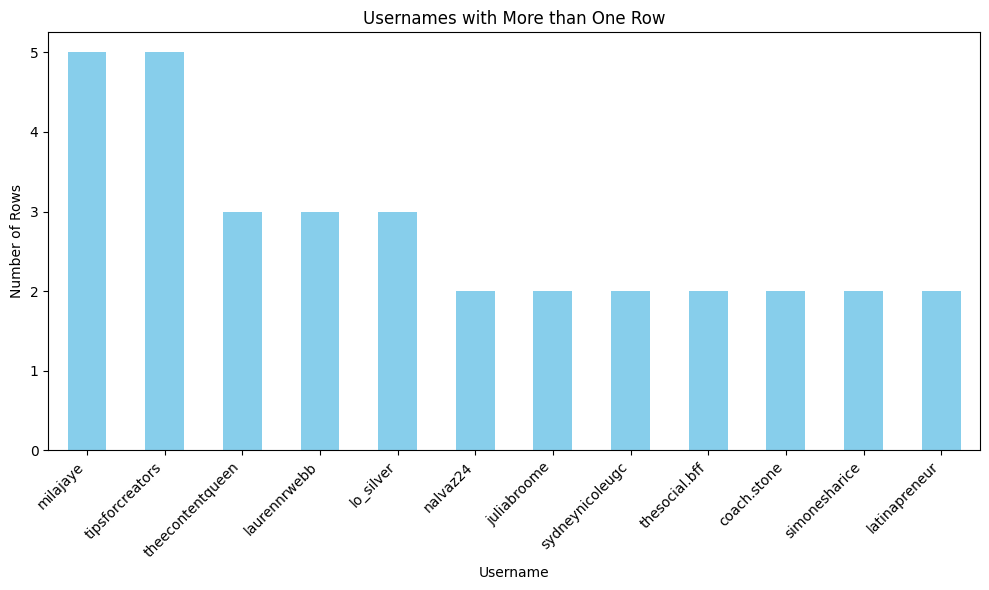

In [8]:
import matplotlib.pyplot as plt

# Some creators appear multiple times in this search. Let's see who they are.
def check_multiple_entries(df):
    # Group by 'username' and count the number of occurrences for each username
    username_counts = df['username'].value_counts()
    
    # Filter for usernames that appear more than once
    duplicate_usernames = username_counts[username_counts > 1]
    
    # Output the usernames and the number of times they appear
    if not duplicate_usernames.empty:
        '''print("Usernames with more than one row:")
        for username, count in duplicate_usernames.items():
            print(f"{username}: {count} rows")'''

        # Plotting the bar chart
        plt.figure(figsize=(10, 6))
        duplicate_usernames.plot(kind='bar', color='skyblue')
        plt.title('Usernames with More than One Row')
        plt.xlabel('Username')
        plt.ylabel('Number of Rows')
        plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
        plt.tight_layout()
        plt.show()
        
    else:
        print("No duplicate usernames found.")
    
    return duplicate_usernames

# Example usage:
duplicate_usernames = check_multiple_entries(df)

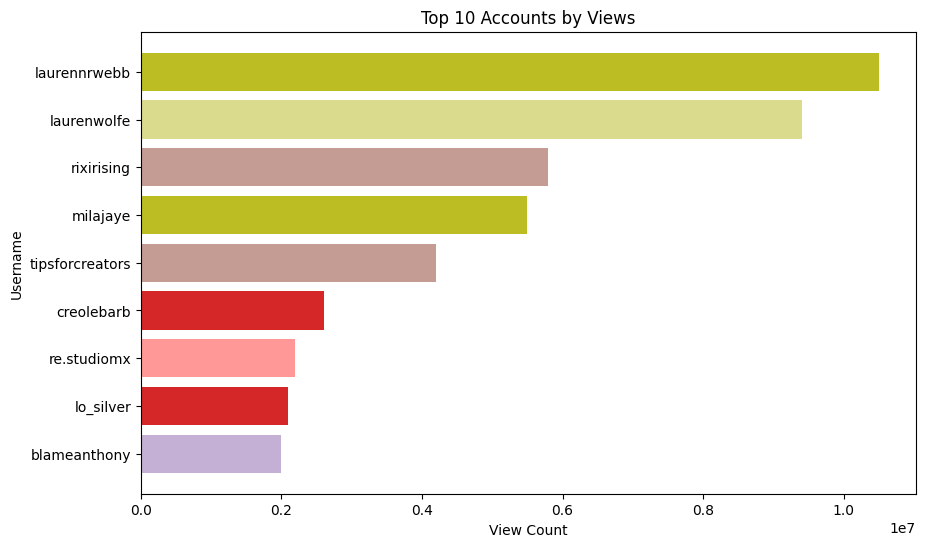

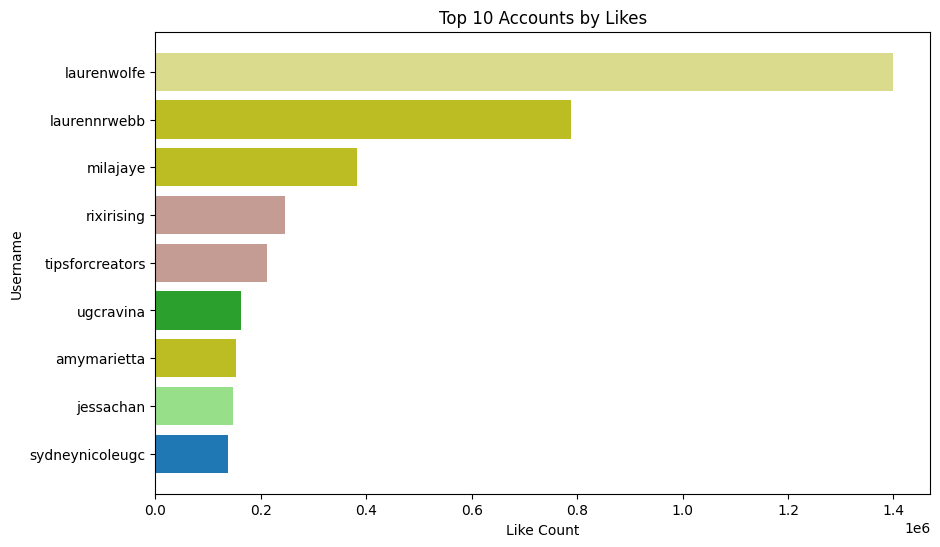

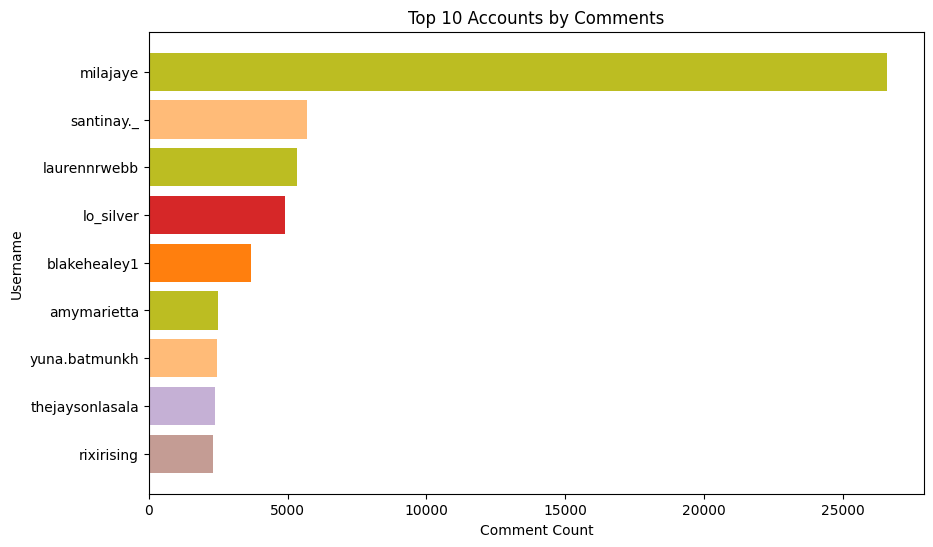

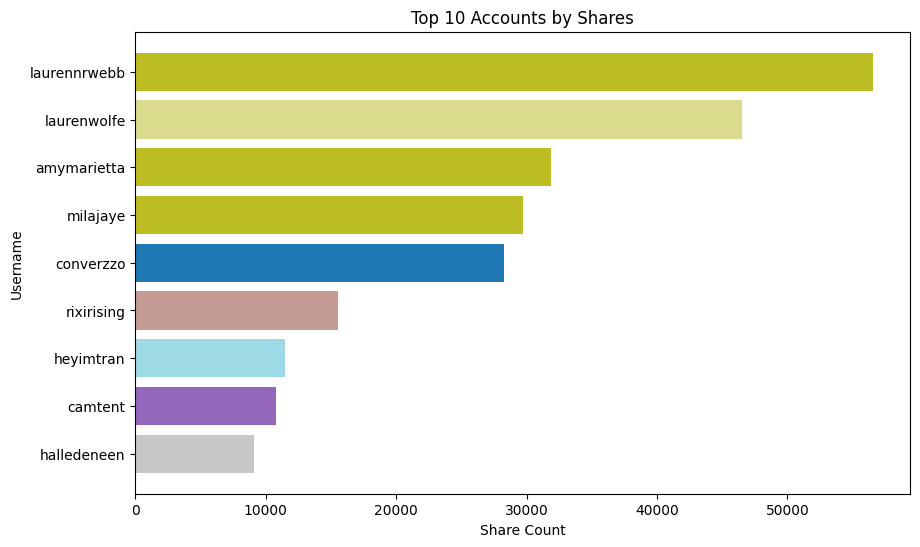

In [9]:
import seaborn as sns

# Function to create a color palette based on unique usernames
def get_color_map(usernames):
    unique_usernames = usernames.unique()  # Get unique usernames
    palette = sns.color_palette('tab20', len(unique_usernames))  # Use 'tab20' palette for more distinct colors
    color_map = {user: color for user, color in zip(unique_usernames, palette)}  # Map each username to a color
    return color_map

# Function to plot the top 10 videos for a given metric, with consistent colors
def plot_top_videos(df, metric, title, xlabel, color_map):
    # Sort the DataFrame by the selected metric and get the top 10
    top_videos = df[['username', metric]].sort_values(by=metric, ascending=False).head(10)

    # Get the corresponding colors for the usernames
    colors = [color_map[user] for user in top_videos['username']]

    # Plot a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_videos['username'], top_videos[metric], color=colors)
    plt.title(f'Top 10 Accounts by {title}')
    plt.xlabel(xlabel)
    plt.ylabel('Username')
    plt.gca().invert_yaxis()  # Invert the y-axis so the highest value is at the top
    plt.show()

# Generate a color map based on all unique usernames in the dataset
color_map = get_color_map(df['username'])

# Plot the top 10 accounts for views, likes, comments, and shares using the consistent color scheme
plot_top_videos(df, 'view_count', 'Views', 'View Count', color_map)
plot_top_videos(df, 'like_count', 'Likes', 'Like Count', color_map)
plot_top_videos(df, 'comment_count', 'Comments', 'Comment Count', color_map)
plot_top_videos(df, 'share_count', 'Shares', 'Share Count', color_map)

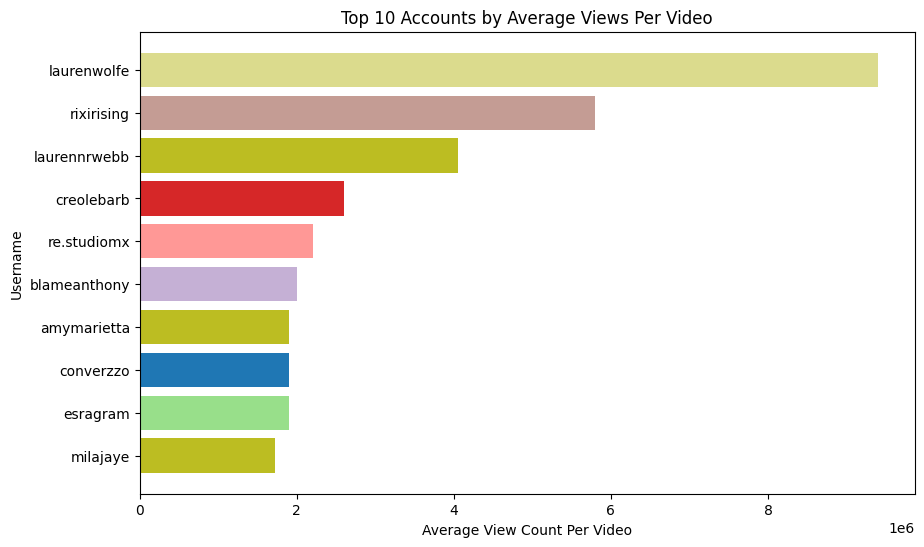

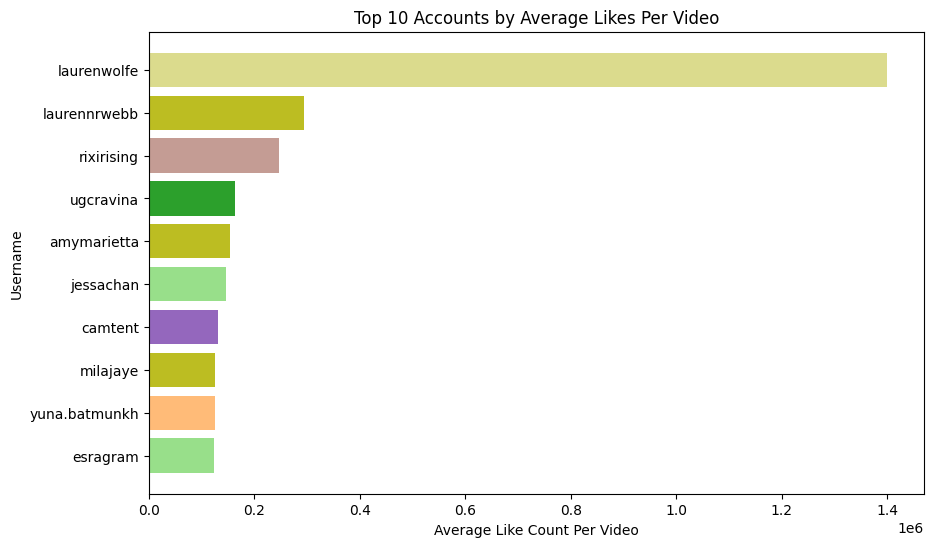

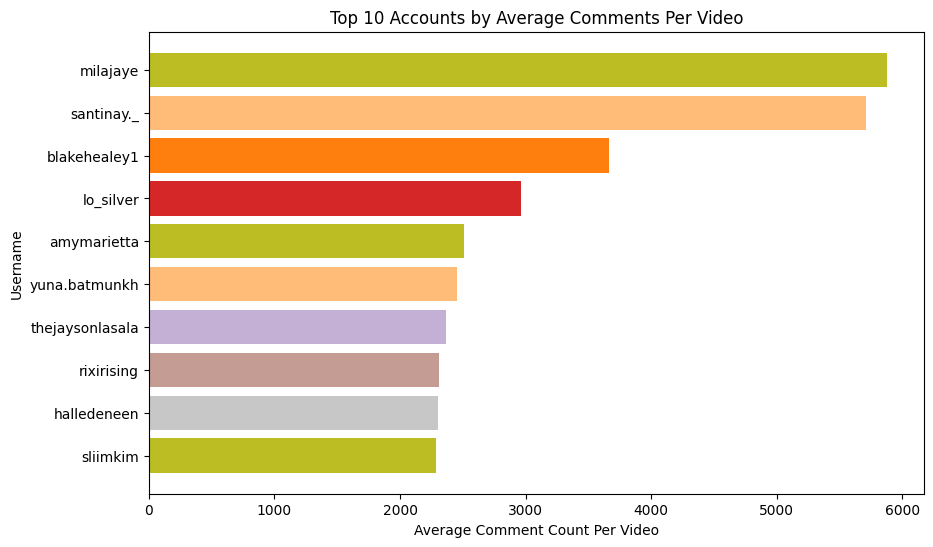

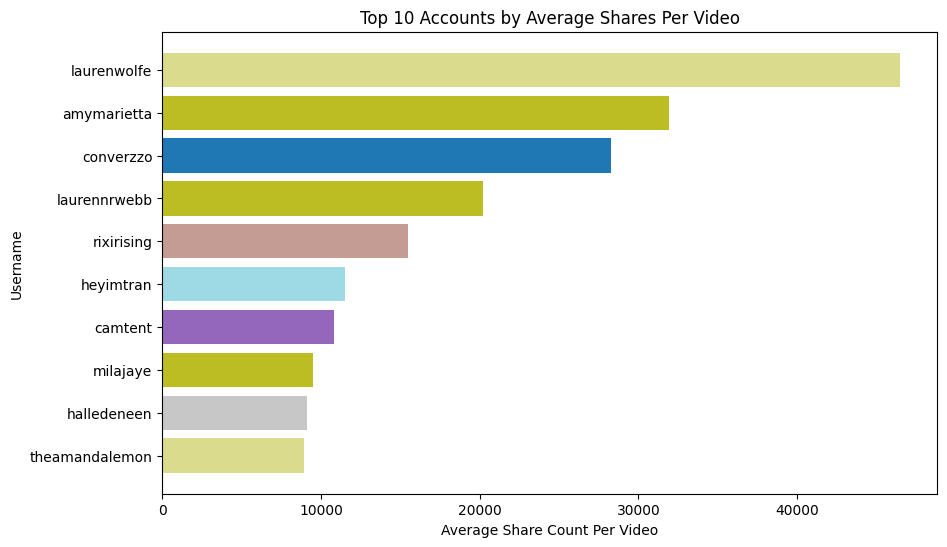

In [10]:
# Have to handle the case that there are multiple videos from the same account in these search results
def aggregate_metrics_per_video(df):
    """
    Aggregates metrics per username and calculates the average performance per video for all metrics.
    :param df: DataFrame containing 'username' and the metrics to be aggregated.
    :return: A new DataFrame with usernames and average performance per video for all metrics.
    """
    # Group by 'username' and calculate the average for each metric
    aggregated = df.groupby('username').agg(
        avg_view_count=('view_count', 'mean'),
        avg_like_count=('like_count', 'mean'),
        avg_comment_count=('comment_count', 'mean'),
        avg_share_count=('share_count', 'mean')
    ).reset_index()  # Reset index to make 'username' a column again
    
    return aggregated

def plot_top_accounts_per_video(df, metric, title, xlabel, color_map):
    """
    Plots the top 10 accounts based on average performance per video for a given metric.
    :param df: DataFrame containing usernames and their metrics.
    :param metric: The metric to be plotted (e.g., 'avg_view_count', 'avg_like_count').
    :param title: Title of the plot.
    :param xlabel: Label for the x-axis.
    :param color_map: Dictionary to ensure consistent coloring across usernames.
    """
    # Aggregate metrics per video using the new aggregate function
    aggregated = aggregate_metrics_per_video(df)
    
    # Sort by the selected metric and get the top 10 accounts
    top_accounts = aggregated.sort_values(by=metric, ascending=False).head(10)
    
    # Get the corresponding colors for the usernames
    colors = [color_map.get(user, 'gray') for user in top_accounts['username']]
    
    # Plot a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_accounts['username'], top_accounts[metric], color=colors)
    plt.title(f'Top 10 Accounts by Average {title} Per Video')
    plt.xlabel(xlabel)
    plt.ylabel('Username')
    plt.gca().invert_yaxis()  # Invert the y-axis so the highest value is at the top
    plt.show()

# Plotting for different metrics
plot_top_accounts_per_video(df, 'avg_view_count', 'Views', 'Average View Count Per Video', color_map)
plot_top_accounts_per_video(df, 'avg_like_count', 'Likes', 'Average Like Count Per Video', color_map)
plot_top_accounts_per_video(df, 'avg_comment_count', 'Comments', 'Average Comment Count Per Video', color_map)
plot_top_accounts_per_video(df, 'avg_share_count', 'Shares', 'Average Share Count Per Video', color_map)


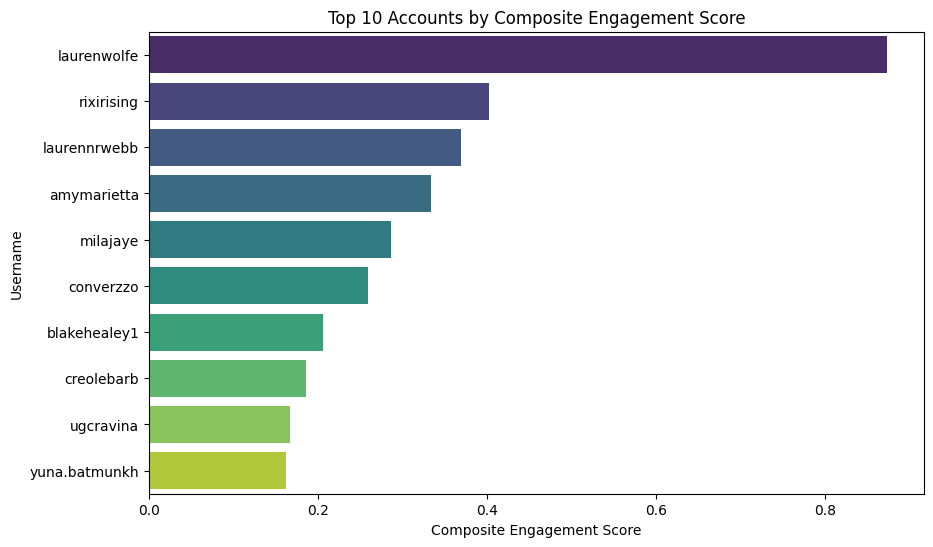

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Normalizing the aggregated data
def normalize_and_calculate_composite_score(df, weight_views=0.35, weight_likes=0.25, weight_comments=0.15, weight_shares=0.25):
    """
    Normalizes the metrics and calculates a composite engagement score based on the given weights.
    :param df: DataFrame containing the average metrics per video per username.
    :param weight_views: Weight for the view count metric.
    :param weight_likes: Weight for the like count metric.
    :param weight_comments: Weight for the comment count metric.
    :param weight_shares: Weight for the share count metric.
    :return: DataFrame with normalized metrics and the composite engagement score.
    """
    # apply normalization
    scaler = MinMaxScaler()
    metrics = df[['avg_view_count', 'avg_like_count', 'avg_comment_count', 'avg_share_count']]
    normalized_metrics = scaler.fit_transform(metrics)

    # Convert back to a DataFrame
    df_normalized = pd.DataFrame(normalized_metrics, columns=['view_count', 'like_count', 'comment_count', 'share_count'])
    df_normalized['username'] = df['username'].values  # Ensure usernames are correctly aligned

    # Calculate the composite score
    df_normalized['engagement_score'] = (
        weight_views * df_normalized['view_count'] +
        weight_likes * df_normalized['like_count'] +
        weight_comments * df_normalized['comment_count'] +
        weight_shares * df_normalized['share_count']
    )

    return df_normalized

# STep 2. Plotting the top accounts based on composite engagement score
def plot_top_accounts(df_normalized):
    
    top_accounts = df_normalized.sort_values(by='engagement_score', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='engagement_score', y='username', data=top_accounts, hue='username', palette='viridis', legend=False)
    plt.title('Top 10 Accounts by Composite Engagement Score')
    plt.xlabel('Composite Engagement Score')
    plt.ylabel('Username')
    plt.show()

# Step 3: Combine everything to process the data and generate the final chart
def process_and_plot(df):
    
    aggregated_df = aggregate_metrics_per_video(df)

    
    df_normalized = normalize_and_calculate_composite_score(aggregated_df)

    
    plot_top_accounts(df_normalized)

process_and_plot(df)

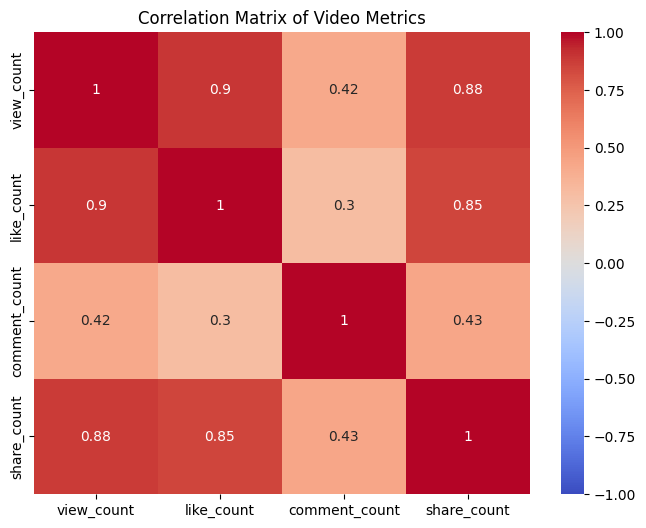

In [12]:
# Set up a correlation matrix to understand how engagement variables and views correlate
metrics_df = df[['view_count', 'like_count', 'comment_count', 'share_count']]

correlation_matrix = metrics_df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Video Metrics')
plt.show()

In [13]:
# Sort the DataFrame by follower_count in ascending order
df = df.sort_values(by='follower_count', ascending=True)

# Create an interactive scatter plot with Plotly and log scale on both axes
fig = px.scatter(df, 
                 x='follower_count', 
                 y='view_count', 
                 hover_name='username',  # Display username when hovering
                 labels={'follower_count': 'Follower Count', 'view_count': 'View Count'},
                 title='View Count vs Follower Count (Log Scale)',
                 log_x=True,  # Apply logarithmic scale to x-axis
                 log_y=True)  # Apply logarithmic scale to y-axis

# Show the plot
fig.show()
